# 🎯 Review: Quick Start Guide 


## 🐊 Getting Started with CSPOT 

Kindly note that **CSPOT is not a plug-and-play solution**. It's a framework that requires significant upfront investment of time from potential users for training and validating deep learning models, which can then be utilized in a plug-and-play manner for processing large volumes of similar multiplexed imaging data.  

Before we set up CSPOT, we highly recommend using a environment manager like Conda. Using an environment manager like Conda allows you to create and manage isolated environments with specific package versions and dependencies. 
  
**Download and Install the right [conda](https://docs.conda.io/en/latest/miniconda.html) based on the opertating system that you are using**

## **Create a new conda environment**

```
# use the terminal (mac/linux) and anaconda promt (windows) to run the following command
conda create --name cspot -y python=3.9
conda activate cspot
```

**Install `cspot` within the conda environment.**

```
pip install cspot
pip install notebook

# after it is installed open the notebook by typing the following in the terminal:
jupyter notebook
```

### Build a CSPOT Model 


Please keep in mind that the [sample data](https://doi.org/10.7910/DVN/C45JWT) is used for demonstration purposes only and has been simplified and reduced in size. It is solely intended for educational purposes on how to execute `cspot` and will not yeild any meaningful results.

<hr>

In [1]:
%%time
# import packages in jupyter notebook (not needed for command line interface users)
import cspot as cs

Instructions for updating:
non-resource variables are not supported in the long term
CPU times: user 3.8 s, sys: 2.74 s, total: 6.54 s
Wall time: 3.37 s


**CSPOT auto generates subfolders and so always set a single folder as `projectDir` and cspot will use that for all subsequent steps.**  
In this case we will set the downloaded sample data as our `projectDir`. My sample data is on my desktop as seen below.

### Change this to your local directory where the example data has been saved

In [2]:
projectDir = '/Users/aj/Downloads/cspotExampleData' #CHANGE

In [3]:
%%time
# set the working directory & set paths to the example data
imagePath = projectDir + '/image/exampleImage.tif'
spatialTablePath = projectDir + '/quantification/exampleSpatialTable.csv'
markerChannelMapPath = projectDir + '/markers.csv'

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs


## Step-1: Generate Thumbnails for Training Data

The first step would be to train a model to recognize the marker of interest. In this example the data contains 11 channels `DNA1, ECAD, CD45, CD4, CD3D, CD8A, CD45R, KI67` and as we are not interested in training a model to recognize DNA or background (`DNA1`), we will only need to generate training data for  `ECAD1, CD45, CD4, CD3D, CD8A & KI67`. However for proof of concept, let us just train a model for `ECAD` and `CD3D`.

To do so, the first step is to create examples of `postive` and `negative` examples for each marker of interest. To facilitate this process, we can use the `generateThumbnails` function in `CSPOT`. Under the hood the function auto identifies the cells that has high and low expression of the marker of interest and cuts out small thumbnails from the image.

In [4]:
%%time
cs.generateThumbnails ( spatialTablePath=spatialTablePath, 
                        imagePath=imagePath, 
                        markerChannelMapPath=markerChannelMapPath,
                        markers=["ECAD", "CD3D"], 
                        markerColumnName='marker',
                        channelColumnName='channel',
                        transformation=True, 
                        maxThumbnails=100, 
                        random_state=0,
                        localNorm=True, 
                        globalNorm=False,
                        x_coordinate='X_centroid', 
                        y_coordinate='Y_centroid',
                        percentiles=[2, 12, 88, 98], 
                        windowSize=64,
                        projectDir=projectDir)


Processing Marker: ECAD
Processing Marker: CD3D
Thumbnails have been generated, head over to "/Users/aj/Downloads/cspotExampleData/CSPOT/Thumbnails" to view results
CPU times: user 2.83 s, sys: 6.38 s, total: 9.21 s
Wall time: 1.19 s


**The output from the above function will be stored under `CSPOT/Thumbnails/`.**  
  
Now that the thumbnails are generated, one would manually go through the `TruePos` folder and `TrueNeg` folder and move files around as necessary. If there are any truly negative thumbnails in the `TruePos` folder, move it to `PosToNeg` folder. Similarly, if there are any truly positive thumbnails in `TrueNeg` folder, move it to `NegToPos` folder. You will often notice that imaging artifacts are captured in the `TruePos` folder and there will also likely be a number of true positives in the `TrueNeg` folder as the field of view (64x64) is larger than what the program used to identify those thumbnails (just the centroids of single cells at the center of that thumbnail).    
  
While you are manually sorting the postives and negative thumbnails, please keep in mind that you are looking for high-confident positives and high-confident negatives. It is absolutely okay to delete off majority of the thumbnails that you are not confident about. This infact makes it easy and fast as you are looking to only keep only thumbnails that are readily sortable.  
  
Lastly, I generally use a whole slide image to generate these thumbnails as there will be enough regions with high expression and no expression of the marker of interest. If you look at the thumbnails of this dummy example, you will notice that most thumbnails of `TrueNeg` for `ECAD` does contain some level of `ECAD` as there is not enough regions to sample from. 

## Step-2: Generate Masks for Training Data

To train the deep learning model, in addition to the raw thumbnails a mask is needed. The mask lets the model know where the cell is located. Ideally one would manually draw on the thumbnails to locate where the positive cells are, however for the pupose of scalability we will use automated approaches to generate the Mask for us. The following function will generate the mask and split the data into `training, validation and test` that can be directly fed into the deep learning algorithm.

In [5]:
%%time
thumbnailFolder = [projectDir + '/CSPOT/Thumbnails/CD3D',
                   projectDir + '/CSPOT/Thumbnails/ECAD']

# The function accepts the four pre-defined folders. If you had renamed them, please change it using the parameter below.
# If you had deleted any of the folders and are not using them, replace the folder name with `None` in the parameter.
cs.generateTrainTestSplit ( thumbnailFolder, 
                            projectDir=projectDir,
                            file_extension=None,
                            TruePos='TruePos', NegToPos='NegToPos',
                            TrueNeg='TrueNeg', PosToNeg='PosToNeg')

Processing: CD3D
Processing: ECAD
Training data has been generated, head over to "/Users/aj/Downloads/cspotExampleData/CSPOT/TrainingData" to view results
CPU times: user 193 ms, sys: 276 ms, total: 469 ms
Wall time: 218 ms


If you head over to `CSPOT/TrainingData/`, you will notice that each of the supplied marker above will have a folder with the associated `training, validataion and test` data that is required by the deep-learning algorithm to generate the model. 

## Step-3: Train the CSPOT Model

The function trains a deep learning model for each marker in the provided training data. To train the `cspotModel`, simply direct the function to the `TrainingData` folder. To train only specific models, specify the folder names using the `trainMarkers` parameter. The 'outputDir' remains constant and the program will automatically create subfolders to save the trained models.

In [6]:
%%time
trainingDataPath = projectDir + '/CSPOT/TrainingData'

cs.csTrain(trainingDataPath=trainingDataPath,
               projectDir=projectDir,
               trainMarkers=None,
               artefactPath=None,
               imSize=64,
               nChannels=1,
               nClasses=2,
               nExtraConvs=0,
               nLayers=3,
               featMapsFact=2,
               downSampFact=2,
               ks=3,
               nOut0=16,
               stdDev0=0.03,
               batchSize=16,
               epochs=1)

Instructions for updating:
Colocations handled automatically by placer.
/Users/aj/Downloads/cspotExampleData/CSPOT/TrainingData/CD3D/training
Training for 8 steps
Found 124 training images
Found 42 validation images
Found 41 test images
Of these, 0 are artefact training images
 and  0 artefact validation images
Using 0 and 1 for mean and standard deviation.
saving data
saving data
Using 15.0 and 0.0 for global max and min intensities.
Class balance ratio is 15.352093476144109


/Users/aj/miniconda3/envs/cspot/lib/python3.9/site-packages/cspot/UNet.py:137: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  bn = tf.nn.leaky_relu(tf.layers.batch_normalization(c00+shortcut, training=UNet2D.tfTraining))
/Users/aj/miniconda3/envs/cspot/lib/python3.9/site-packages/cspot/UNet.py:159: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  lbn = tf.nn.leaky_relu(tf.layers.batch_normalization(
/Users/aj/miniconda3/envs/cspot/lib/python3.9/site-packages/cspot/UNet.py

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
step 00000, e: 0.526497, epoch: 1
Model saved in file: /Users/aj/Downloads/cspotExampleData/CSPOT/cspotModel/CD3D/model.ckpt
step 00001, e: 0.480866, epoch: 1
step 00002, e: 0.533251, epoch: 1
step 00003, e: 0.519985, epoch: 1
step 00004, e: 0.501891, epoch: 1
step 00005, e: 0.507230, epoch: 1
step 00006, e: 0.465878, epoch: 2
step 00007, e: 0.505098, epoch: 2
saving data
loading data
INFO:tensorflow:Restoring parameters from /Users/aj/Downloads/cspotExampleData/CSPOT/cspotModel/CD3D/model.ckpt
Model restored.
/Users/aj/Downloads/cspotExampleData/CSPOT/TrainingData/ECAD/training
Training for 9 steps
Found 142 training images
Found 48 validation images
Found 47 test im

## Step-4: Predict on a new image

Now that the model is trained, we can predict the expression of the trained markers on a new image that the model has not seen before. 

In [7]:
%%time
# cspotpredict related paths
csModelPath = projectDir + '/manuscriptModels/'
segmentationPath = projectDir + '/segmentation/exampleSegmentationMask.tif'

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


In [8]:
%%time
# Run the pipeline (For function specific parameters, check the documentation)
cs.csPipeline(   
                    # parameters for cspotPredict function
                    imagePath=imagePath,
                    csModelPath=csModelPath,
                    markerChannelMapPath=markerChannelMapPath,

                    # parameters for cspotCScore function
                    segmentationMaskPath=segmentationPath,

                    # parameters for cspotObject function
                    spatialTablePath=spatialTablePath,

                    # common parameters
                    verbose=False,
                    projectDir=projectDir)


loading data
loading data
loading data
INFO:tensorflow:Restoring parameters from /Users/aj/Downloads/cspotExampleData/manuscriptModels/ECAD/model.ckpt
Model restored.


/Users/aj/miniconda3/envs/cspot/lib/python3.9/site-packages/cspot/UNet.py:137: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  bn = tf.nn.leaky_relu(tf.layers.batch_normalization(c00+shortcut, training=UNet2D.tfTraining))
/Users/aj/miniconda3/envs/cspot/lib/python3.9/site-packages/cspot/UNet.py:159: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  lbn = tf.nn.leaky_relu(tf.layers.batch_normalization(
/Users/aj/miniconda3/envs/cspot/lib/python3.9/site-packages/cspot/UNet.py

Inference...
loading data
loading data
loading data
INFO:tensorflow:Restoring parameters from /Users/aj/Downloads/cspotExampleData/manuscriptModels/CD3D/model.ckpt
Model restored.
Inference...
CPU times: user 1min 10s, sys: 25.5 s, total: 1min 36s
Wall time: 15.9 s


/Users/aj/miniconda3/envs/cspot/lib/python3.9/site-packages/cspot/cspot.py:393: RuntimeWarning: invalid value encountered in divide
  below_midpoint = (below_midpoint - min_below) / range_below


Head over to `CSPOT/cspotOutput` to view results

## Visualize the results

Let us visualize the marker postivity of three markers using a helper plotting function provided within CSPOT.

CPU times: user 383 ms, sys: 4.62 ms, total: 388 ms
Wall time: 197 ms


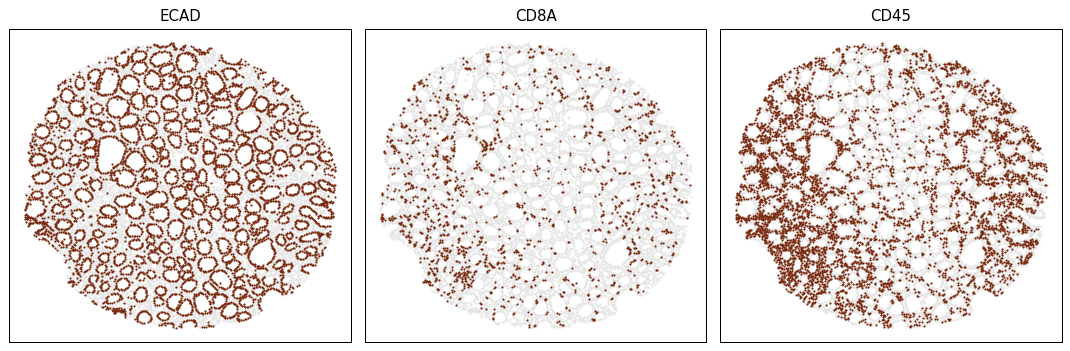

In [9]:
%%time
csObject = projectDir + '/CSPOT/cspotOutput/exampleImage_cspotPredict.ome.h5ad'

# Plot image to console
cs.scatterPlot(csObject,
            markers=['ECAD', 'CD8A', 'CD45'],
            poscellsColor='#78290f',
            negcellsColor='#e5e5e5',
            s=3,
            ncols=3,
            dpi=90,
            figsize=(4, 4),
            outputDir=None,
            outputFileName='cspotplot.png')

## Step-5: CSPOT Phenotyping
Assign phenotypes to each cell. Clustering data may not always be ideal, so we developed a cell type assignment algorithm that does a hierarchical assignment process iteratively.
  
Please keep in mind that the sample data is used for demonstration purposes only and has been simplified and reduced in size. It is solely intended for educational purposes on how to execute `cspot` and will not yeild any meaningful results.

In [10]:
%%time
# import packages
import pandas as pd

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 4.05 µs


**We need `two` basic inputs to perform phenotyping with CSPOT**
- The cspot Object
- A Phenotyping workflow based on prior knowledge

In [11]:
%%time
# Path to the CSPOT Object
csObject = projectDir + '/CSPOT/csObject/exampleImage_cspotPredict.ome.h5ad'

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.29 µs


In [12]:
%%time
# load the phenotyping workflow
phenotype = pd.read_csv(str(projectDir) + '/phenotype_workflow.csv')
# view the table:
phenotype.style.format(na_rep='')

CPU times: user 46.1 ms, sys: 2.16 ms, total: 48.3 ms
Wall time: 16.9 ms


,Unnamed: 0,Unnamed: 1,ECAD,CD45,CD4,CD3D,CD8A,KI67
0,all,Immune,,anypos,anypos,anypos,anypos,
1,all,ECAD+,pos,,,,,
2,ECAD+,KI67+ ECAD+,,,,,,pos
3,Immune,CD4+ T,,,allpos,allpos,,
4,Immune,CD8+ T,,,,allpos,allpos,
5,Immune,Non T CD4+ cells,,,pos,neg,,


As it can be seen from the table above,  
(1) The `first column` has to contain the cell that are to be classified.  
(2) The `second column` indicates the phenotype a particular cell will be assigned if it satifies the conditions in the row.  
(3) `Column three` and onward represent protein markers. If the protein marker is known to be expressed for that cell type, then it is denoted by either `pos`, `allpos`. If the protein marker is known to not express for a cell type it can be denoted by `neg`, `allneg`. If the protein marker is irrelevant or uncertain to express for a cell type, then it is left empty. `anypos` and `anyneg` are options for using a set of markers and if any of the marker is positive or negative, the cell type is denoted accordingly.

**To give users maximum flexibility in identifying desired cell types, we have implemented various classification arguments as described above for strategical classification. They include**

- allpos
- allneg
- anypos
- anyneg
- pos
- neg
  
`pos` : "Pos" looks for cells positive for a given marker. If multiple markers are annotated as `pos`, all must be positive to denote the cell type. For example, a Regulatory T cell can be defined as `CD3+CD4+FOXP3+` by passing `pos` to each marker. If one or more markers don't meet the criteria (e.g. CD4-), the program will classify it as `Likely-Regulatory-T cell`, pending user confirmation. This is useful in cases of technical artifacts or when cell types (such as cancer cells) are defined by marker loss (e.g. T-cell Lymphomas).
  
`neg` : Same as `pos` but looks for negativity of the defined markers. 
  
`allpos` : "Allpos" requires all defined markers to be positive. Unlike `pos`, it doesn't classify cells as `Likely-cellType`, but strictly annotates cells positive for all defined markers.
  
`allneg` : Same as `allpos` but looks for negativity of the defined markers. 
  
`anypos` : "Anypos" requires only one of the defined markers to be positive. For example, to define macrophages, a cell could be designated as such if any of `CD68`, `CD163`, or `CD206` is positive.
  
`anyneg` : Same as `anyneg` but looks for negativity of the defined markers. 

In [13]:
%%time
adata = cs.csPhenotype ( csObject=csObject,
                            phenotype=phenotype,
                            midpoint = 0.5,
                            label="phenotype",
                            imageid='imageid',
                            pheno_threshold_percent=None,
                            pheno_threshold_abs=None,
                            fileName=None,
                            projectDir=projectDir)


Phenotyping Immune
Phenotyping ECAD+
-- Subsetting ECAD+
Phenotyping KI67+ ECAD+
-- Subsetting Immune
Phenotyping CD4+ T
Phenotyping CD8+ T
Phenotyping Non T CD4+ cells
Consolidating the phenotypes across all groups
Modified csObject is stored at "/Users/aj/Downloads/cspotExampleData/CSPOT/csPhenotype
CPU times: user 243 ms, sys: 9.24 ms, total: 252 ms
Wall time: 91.9 ms


/Users/aj/miniconda3/envs/cspot/lib/python3.9/site-packages/cspot/csPhenotype.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allpos_score['score'] = allpos_score.max(axis=1)
/Users/aj/miniconda3/envs/cspot/lib/python3.9/site-packages/cspot/csPhenotype.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allpos_score['score'] = allpos_score.max(axis=1)


**If you had provided `projectDir` the modified csObject would be stored in `CSPOT/csPhenotype/`, else, the object will be returned to memory.**

In [14]:
%%time
# check the identified phenotypes
adata.obs['phenotype'].value_counts()

CPU times: user 3.43 ms, sys: 513 µs, total: 3.95 ms
Wall time: 907 µs


KI67+ ECAD+    6159
CD4+ T         5785
CD8+ T          816
Name: phenotype, dtype: int64